In [1]:
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
path = '/home/mr1142/Documents/Data/NIH/images_005'
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

# Set de validación

In [159]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/segmentation/splited/validation'

In [160]:
masks_name = [f for f in os.listdir(os.path.join(path, 'mascara')) 
              if os.path.isfile(os.path.join(os.path.join(path, 'mascara'), f))]

In [6]:
pixels = 256

In [15]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end='')
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [16]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)
    # return img/np.max(img)

In [17]:
def binarize(img):
    img[img>0] = 1
    return img

In [26]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

In [27]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(path, 'images', masks_name[i]))

In [28]:
masks.shape

(99, 256, 256, 1)

# Preprocesado de imagen de entrada al modelo

In [7]:
modelos = os.listdir('/home/mr1142/Documents/Data/models')
modelos.sort()
modelos

['imagenes.h5',
 'mask_1.h5',
 'ueff_1.h5',
 'ueff_2.h5',
 'uloss_1.h5',
 'uloss_2.h5',
 'uloss_albumentation_ gamma_3_validation_2.h5',
 'uloss_albumentation_rotate_3_validation_1.h5',
 'uloss_albumentation_rotate_3_validation_2.h5',
 'uloss_nuevos_validation_mejora_1.h5',
 'uloss_nuevos_validation_mejora_2.h5',
 'uloss_nuevos_validation_mejora_3.h5',
 'uloss_renacimiento_validation_2.h5',
 'uloss_renacimiento_validation_3.h5',
 'uloss_renacimiento_validation_4.h5',
 'uloss_validation_rotate_normalization_1.h5',
 'uloss_validation_rotate_normalization_2.h5',
 'uloss_validation_rotate_normalization_3.h5',
 'unet3.h5',
 'unet_1.h5',
 'unet_2.h5',
 'unet_3.h5',
 'unet_albumentation_ gamma_3_validation_2.h5',
 'unet_albumentation_2_validation_1.h5',
 'unet_albumentation_2_validation_2.h5',
 'unet_albumentation_2_validation_3.h5',
 'unet_albumentation_rotate_3_validation_1.h5',
 'unet_albumentation_rotate_3_validation_2.h5',
 'unet_nuevos_validation_mejora_1.h5',
 'unet_nuevos_validation_m

In [19]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [9]:
def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = ex.dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + 0.5*loss2
    return loss

In [10]:
def apply_mask(img, mask):
    img[mask!=1]=0
    return img

# 1 canal

In [11]:
unet = keras.models.load_model('/home/mr1142/Documents/Data/models/unet_renacimiento_validation_2.h5', 
                                     custom_objects={"loss_mask": loss_mask, 
                                                     "dice_coef_loss": dice_coef_loss,
                                                     "dice_coef": dice_coef})

In [13]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)
    # return img/np.max(img)

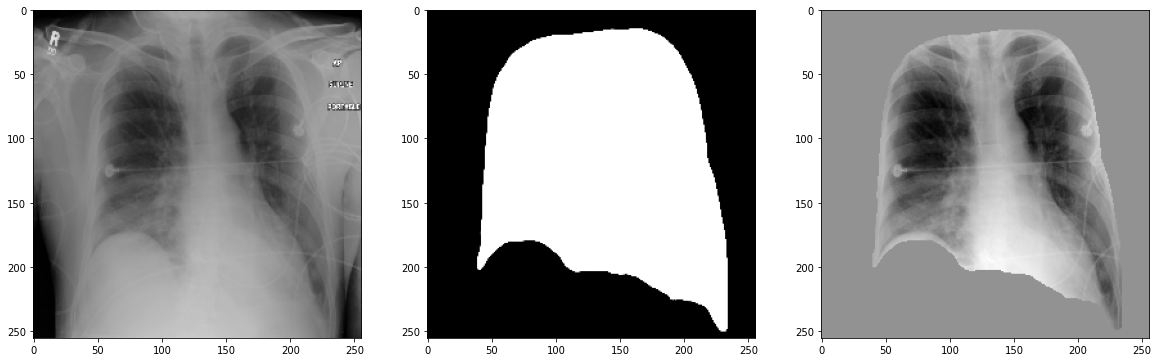

In [52]:
r = np.random.randint(0, len(masks_name))
img = normalize(read_img(path, 'images', masks_name[r]))
mask = unet.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

# 3 canales

In [132]:
unet_model = keras.models.load_model('/home/mr1142/Documents/Data/models/unet3.h5')

In [133]:
def apply_mask_3(img, mask):
    mask = mask[...,1]
    mask = cv2.blur(mask, (5,5))
    mask[mask>0.3]=1
    img[mask!=1]=0
    return img

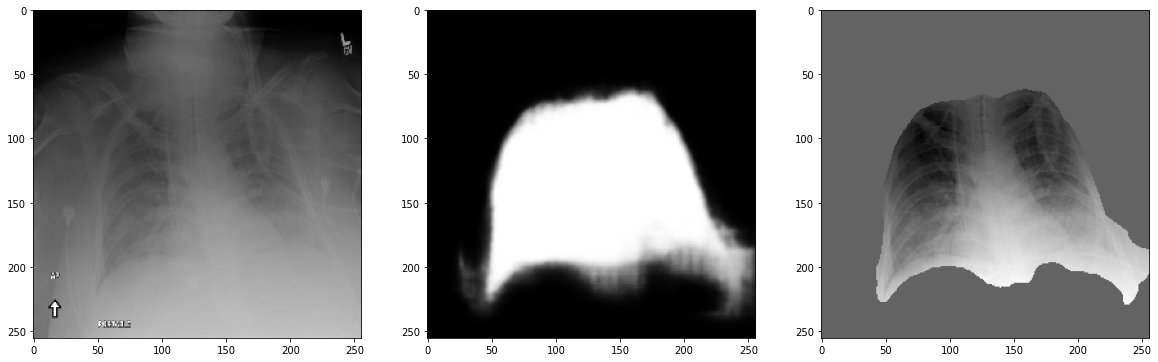

In [134]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask[...,1], cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask_3(img, mask), cmap = 'gray')
plt.show()

In [135]:
results = unet_model.evaluate(images, masks, batch_size=8)

13/13 [==============================] - 26s 1s/step - loss: 1.5964 - accuracy: 0.6789 - mean_squared_error: 0.4447


# Custom loss

In [17]:
import tensorflow as tf

In [18]:
masks_name = os.listdir('/home/mr1142/Documents/Data/segmentation/mascara')

In [19]:
def read_mask(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [20]:
mask = binarize(read_img('/home/mr1142/Documents/Data/segmentation/', 'mascara', masks_name[0]))

In [22]:
mask_model = keras.models.load_model('/home/mr1142/Documents/Data/models/mask_1.h5', 
                                     custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

In [ ]:
sub_mask = tf.keras.Model(inputs=mask_model.input, outputs=mask_model.layers[18].output)

In [ ]:
mask2 = sub_mask.predict(mask[np.newaxis,...])

In [ ]:
unet_model = keras.models.load_model('/home/mr1142/Documents/Data/models/uloss_after_loss_correction_6_0.3.h5', 
                                     custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

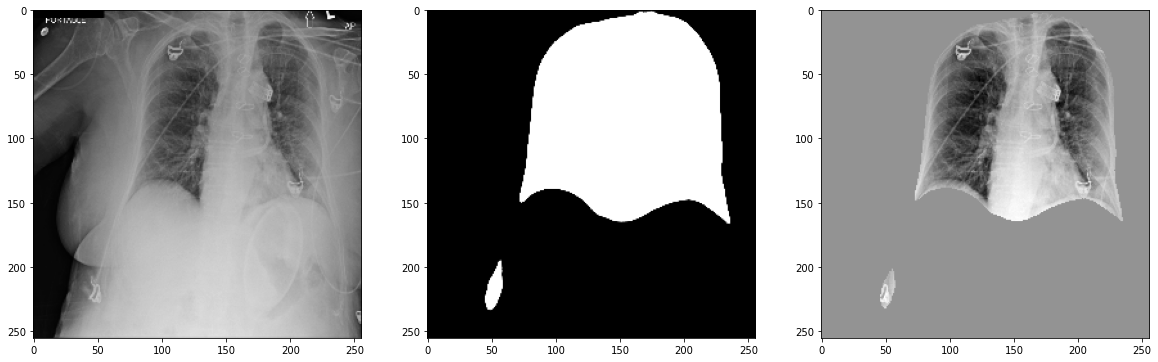

In [113]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict([img[np.newaxis,...], mask[np.newaxis,...], mask2])[1][0]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

# Custom loss mejorada

In [105]:
import tensorflow as tf

In [54]:
uloss = keras.models.load_model('/home/mr1142/Documents/Data/models/uloss_renacimiento_validation_4.h5', 
                                     custom_objects={"MyLoss": MyLoss, 
                                                     "loss_mask": loss_mask, 
                                                     "dice_coef_loss": dice_coef_loss,
                                                     "dice_coef": dice_coef})

In [55]:
def normalize(img):
    # return (img - np.mean(img))/ np.std(img)
    return img/np.max(img)

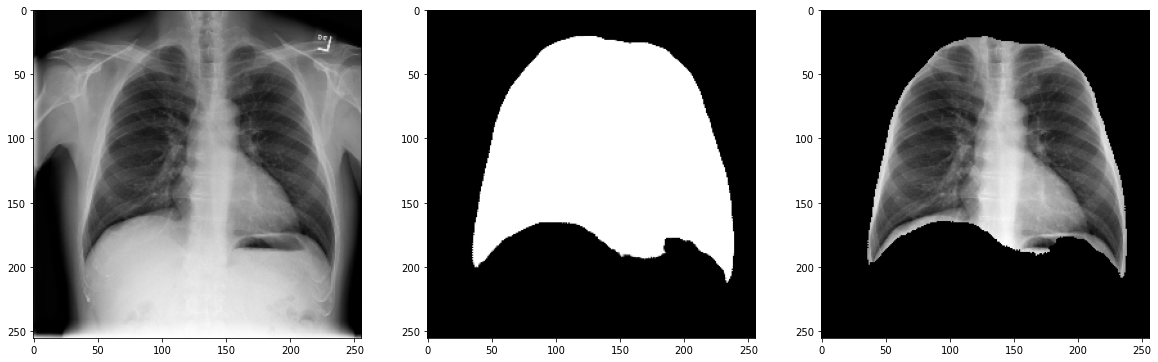

In [63]:
r = np.random.randint(0, len(masks_name))
img = normalize(read_img(path, 'images', masks_name[r]))
mask = uloss.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

# Comparación

In [147]:
import pandas as pd
import re

In [144]:
df = pd.read_csv('/home/mr1142/Documents/Data/segmentation/splited/validation/validation_data.csv')

In [145]:
df.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,833,00000204_002.png,Nodule|Pleural_Thickening,2,204,29,M,PA,2048,2500,0.168,0.168,NaN
1,1279,00000324_002.png,No Finding,2,324,32,M,PA,2992,2991,0.143,0.143,NaN
2,2031,00000522_000.png,Atelectasis|Infiltration,0,522,17,M,AP,2048,2500,0.171,0.171,NaN
3,2626,00000693_004.png,Mass,4,693,62,M,PA,2500,2048,0.168,0.168,NaN
4,5594,00001504_001.png,No Finding,1,1504,66,M,AP,2500,2048,0.168,0.168,NaN


In [148]:
labels = [re.split('[|]', df['Finding Labels'][i]) for i in df.index]
labels = [x for xs in labels for x in xs]
labels = list(np.unique(labels))
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [204]:
label = 'Pneumothorax'

In [205]:
index = [i for i in df.index if bool(re.search(label, df['Finding Labels'][i]))]

In [206]:
len(index)

8

In [207]:
masks_name = list(df['Image Index'][index])

In [ ]:
r = np.random.randint(0, len(masks_name))
img = normalize(read_img(path, 'images', masks_name[r]))
net_mask = unet.predict(img[np.newaxis,...])[0,...]
loss_mask = uloss.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(apply_mask(img, loss_mask), cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, net_mask), cmap = 'gray')
plt.show()